In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr

## Growing Season SPEI vs. Percent Forest Loss

In [3]:
# load data
spei_df = pd.read_csv('district_province_spei_stats.csv')

# rename season_year column for compatability with forest loss
spei_df = spei_df.rename(columns={'season_year': 'year', 'mean_growing_spei': 'mean_spei', 'median_growing_spei': 'median_spei'})

# load forest loss data
forest_df = pd.read_csv('district_forest_cover.csv')
forest_df['year'] = forest_df['year'].astype(int)

In [3]:
spei_df.head()

Unnamed: 0.1  Unnamed: 0 district  year  mean_spei  median_spei  n_months  \
0             0           0  Chadiza  2000   0.838769     0.781813         6   
1             1           1  Chadiza  2001   0.353488     0.303945         6   
2             2           2  Chadiza  2002   0.281255     0.244052         6   
3             3           3  Chadiza  2003   0.227219     0.217295         5   
4             4           4  Chadiza  2004   0.025194     0.084612         6   

  province province_avg_start_date province_avg_end_date  
0  Eastern             November 26                May 04  
1  Eastern             November 26                May 04  
2  Eastern             November 26                May 04  
3  Eastern             November 26                May 04  
4  Eastern             November 26                May 04

In [4]:
forest_df.head()

district  year  forest_cover_ha       loss_m2  percent_loss_annual
0  Chadiza  2001     57181.013721  5.136993e+05             0.089757
1  Chadiza  2002     57127.207503  5.380622e+05             0.094098
2  Chadiza  2003     56960.977318  1.662302e+06             0.290983
3  Chadiza  2004     56773.795452  1.871819e+06             0.328614
4  Chadiza  2005     56703.324923  7.047053e+05             0.124125

In [4]:
# merge SPEI and forest data
merged_df = pd.merge(spei_df, forest_df, on=['district', 'year'])
merged_df.head()

Unnamed: 0.1  Unnamed: 0 district  year  mean_spei  median_spei  n_months  \
0             1           1  Chadiza  2001   0.353488     0.303945         6   
1             2           2  Chadiza  2002   0.281255     0.244052         6   
2             3           3  Chadiza  2003   0.227219     0.217295         5   
3             4           4  Chadiza  2004   0.025194     0.084612         6   
4             5           5  Chadiza  2005  -0.712003    -0.763748         5   

  province province_avg_start_date province_avg_end_date  forest_cover_ha  \
0  Eastern             November 26                May 04     57181.013721   
1  Eastern             November 26                May 04     57127.207503   
2  Eastern             November 26                May 04     56960.977318   
3  Eastern             November 26                May 04     56773.795452   
4  Eastern             November 26                May 04     56703.324923   

        loss_m2  percent_loss_annual  
0  5.136993e+05             0.089757  
1  5.380622e+05             0.094098  
2  1.662302e+06             0.290983  
3  1.871819e+06             0.328614  
4  7.047053e+05             0.124125

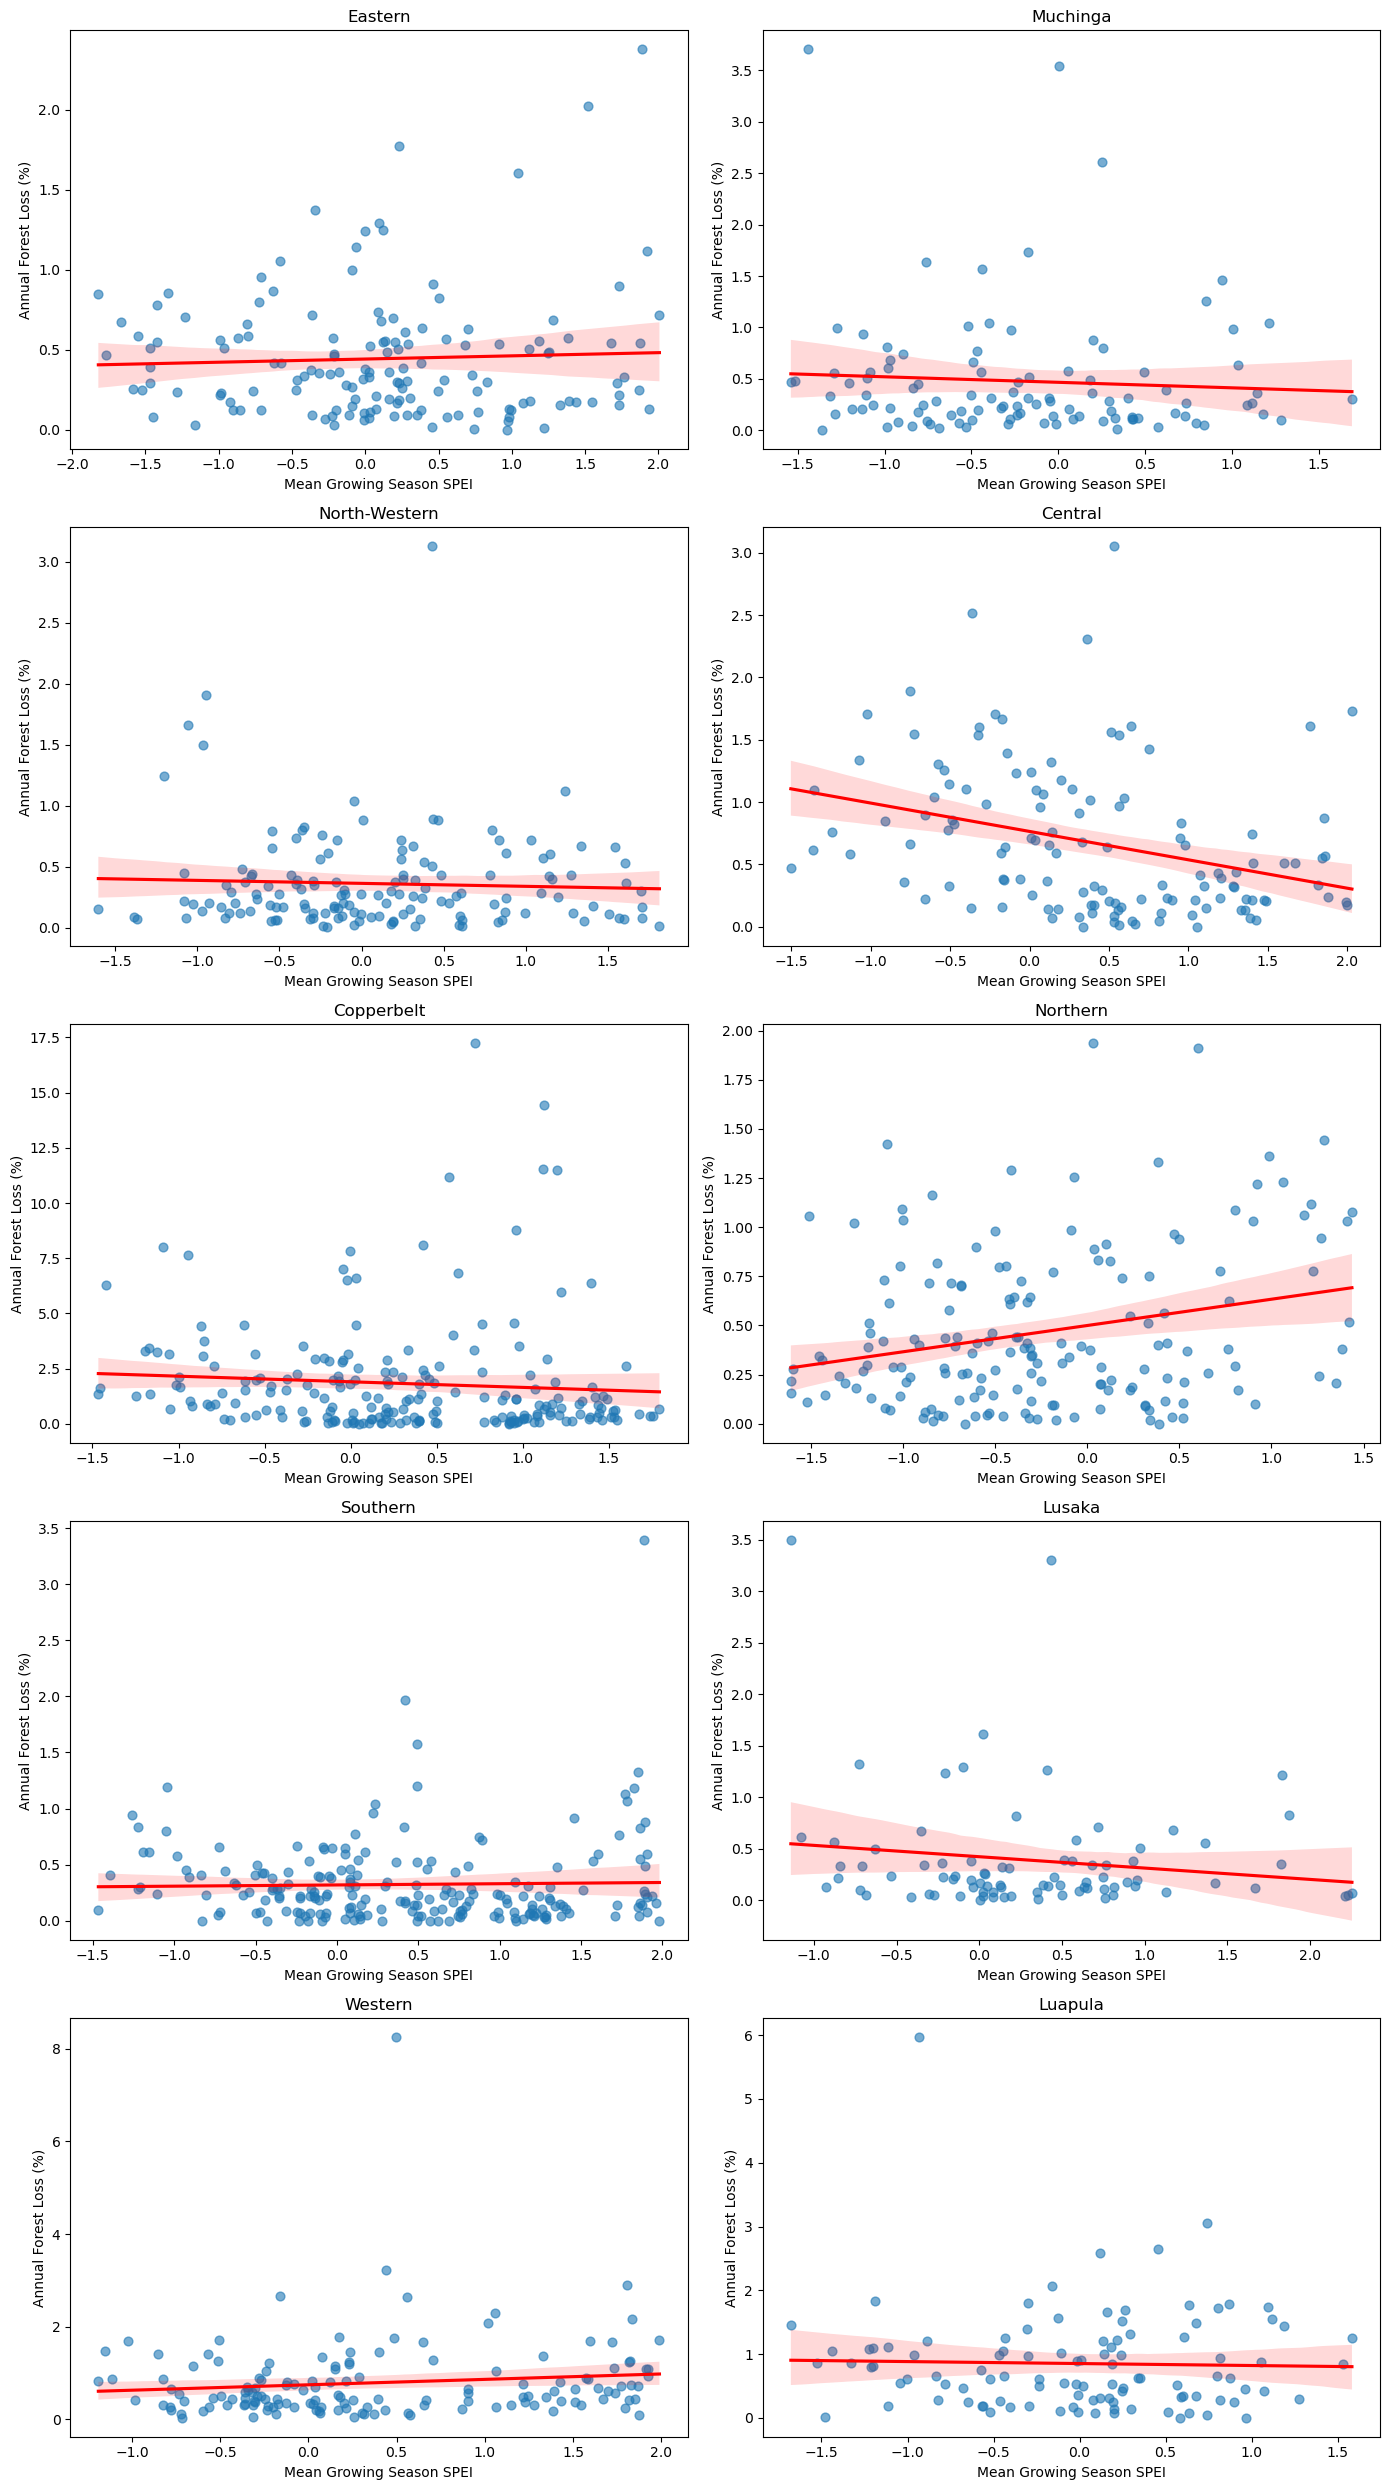

In [11]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'mean_spei', 'percent_loss_annual', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='mean_spei',
        y='percent_loss_annual',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Mean Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (%)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

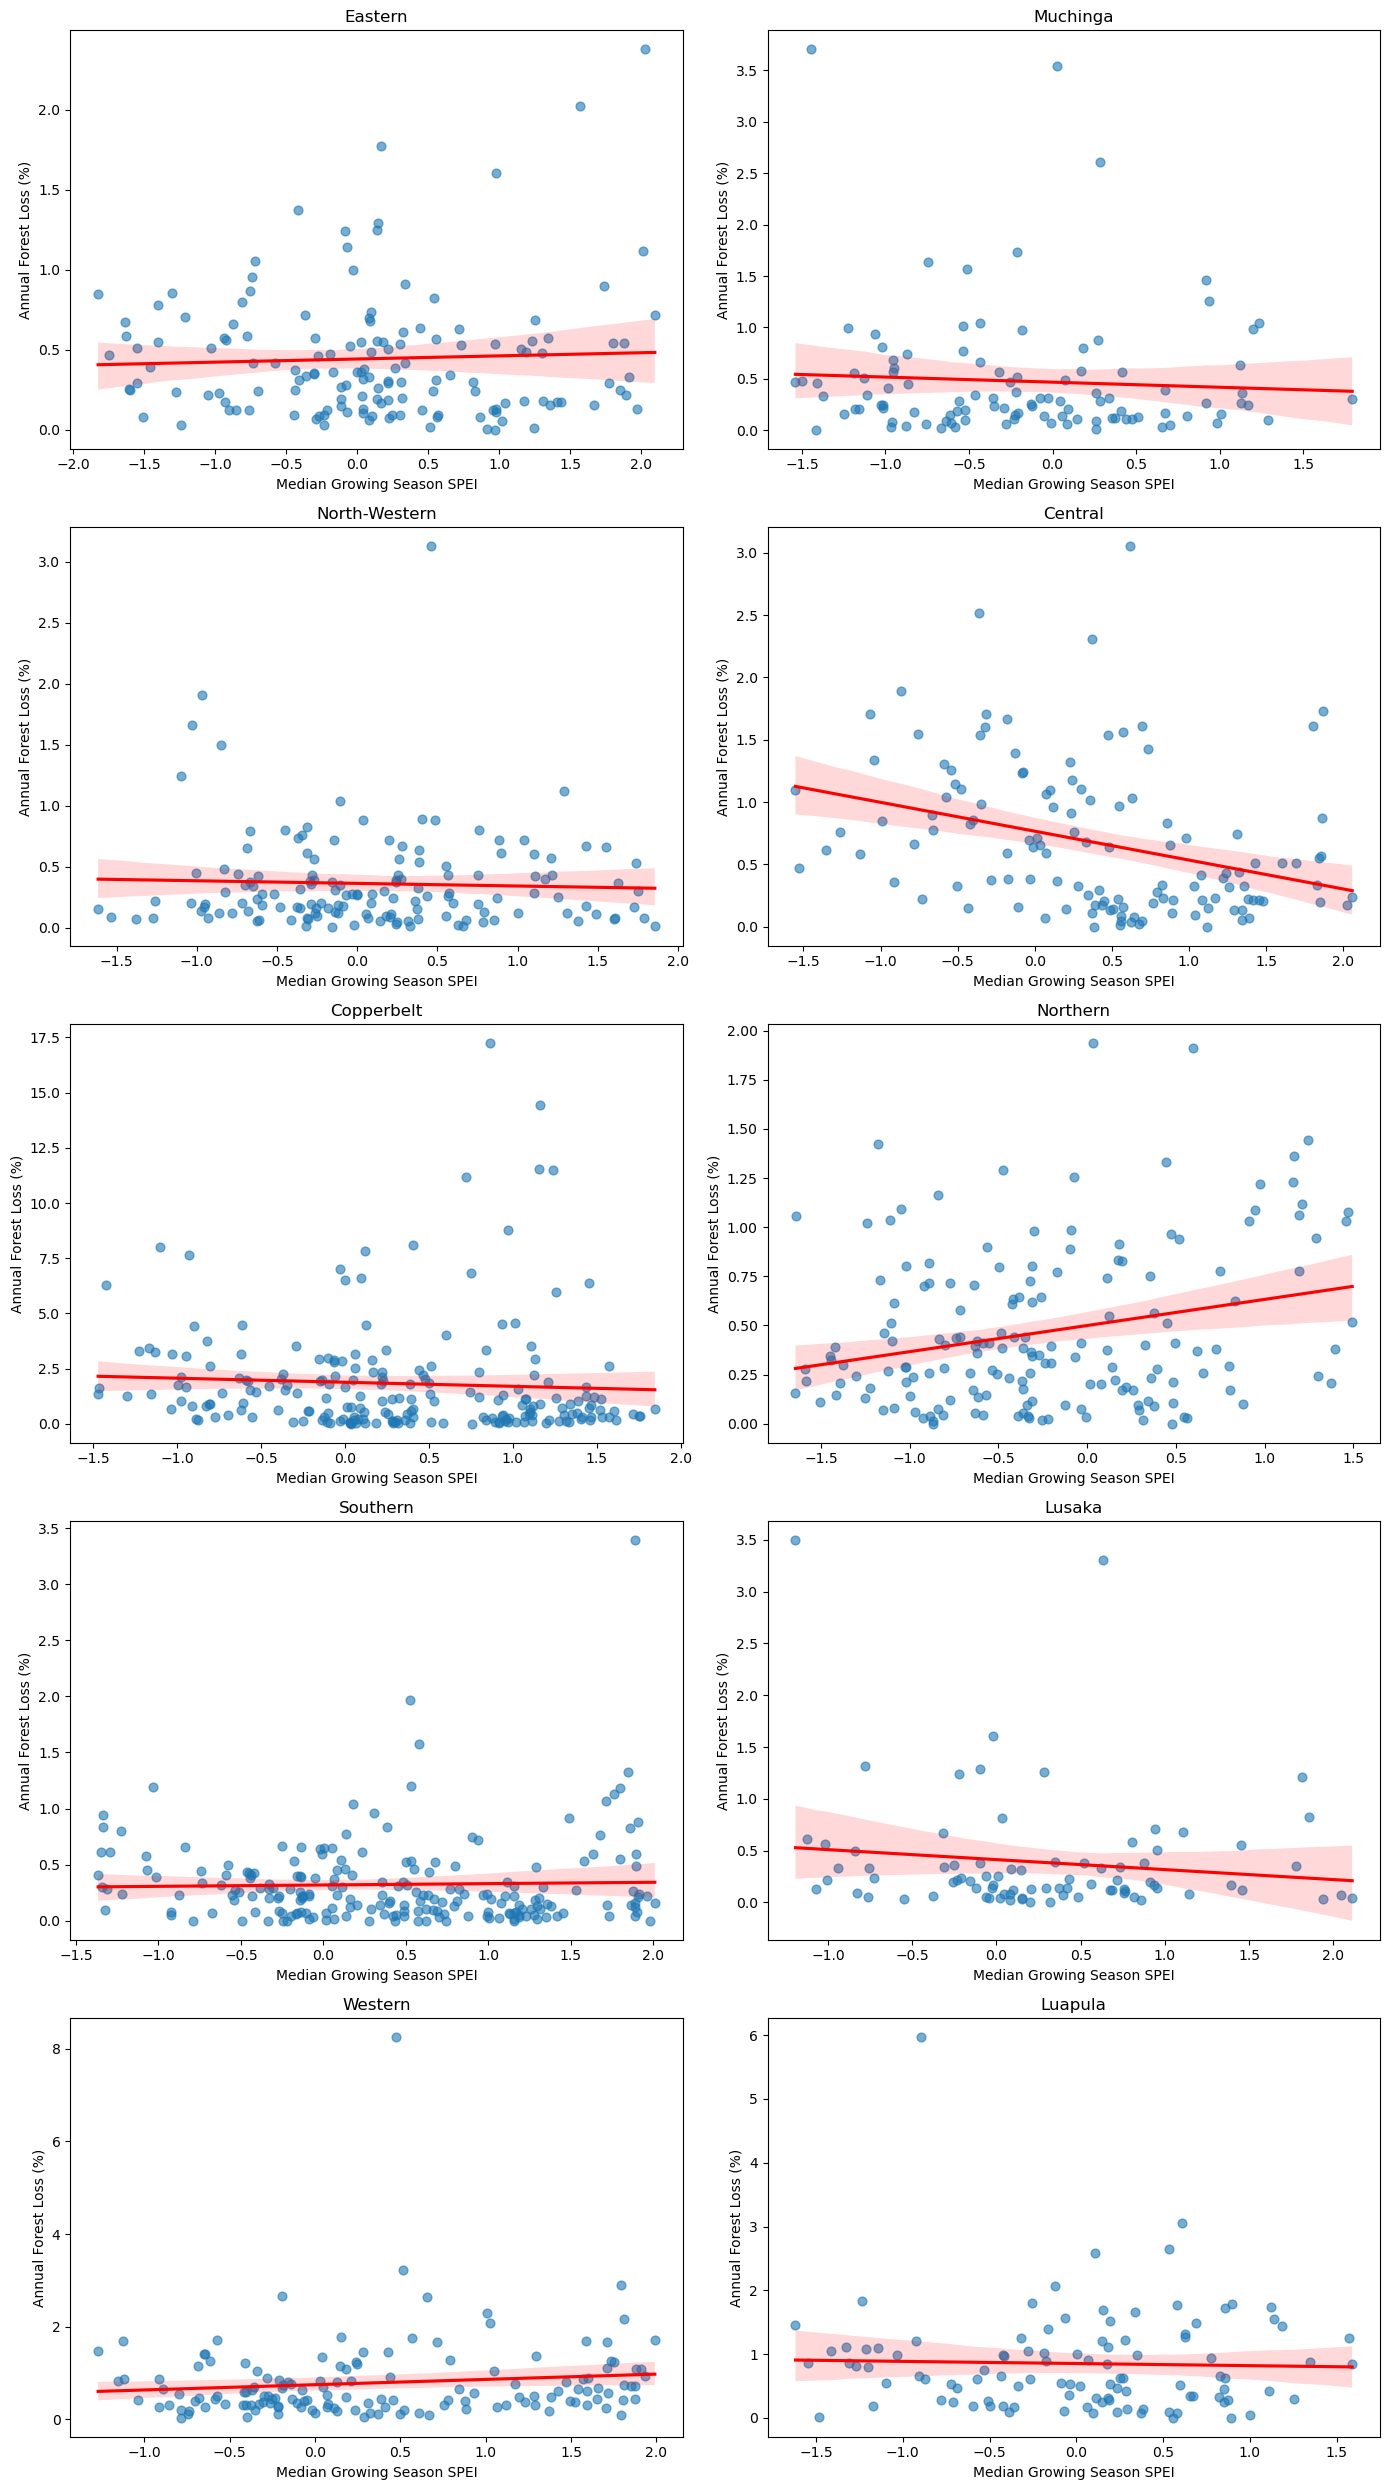

In [12]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'median_spei', 'percent_loss_annual', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='median_spei',
        y='percent_loss_annual',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Median Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (%)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

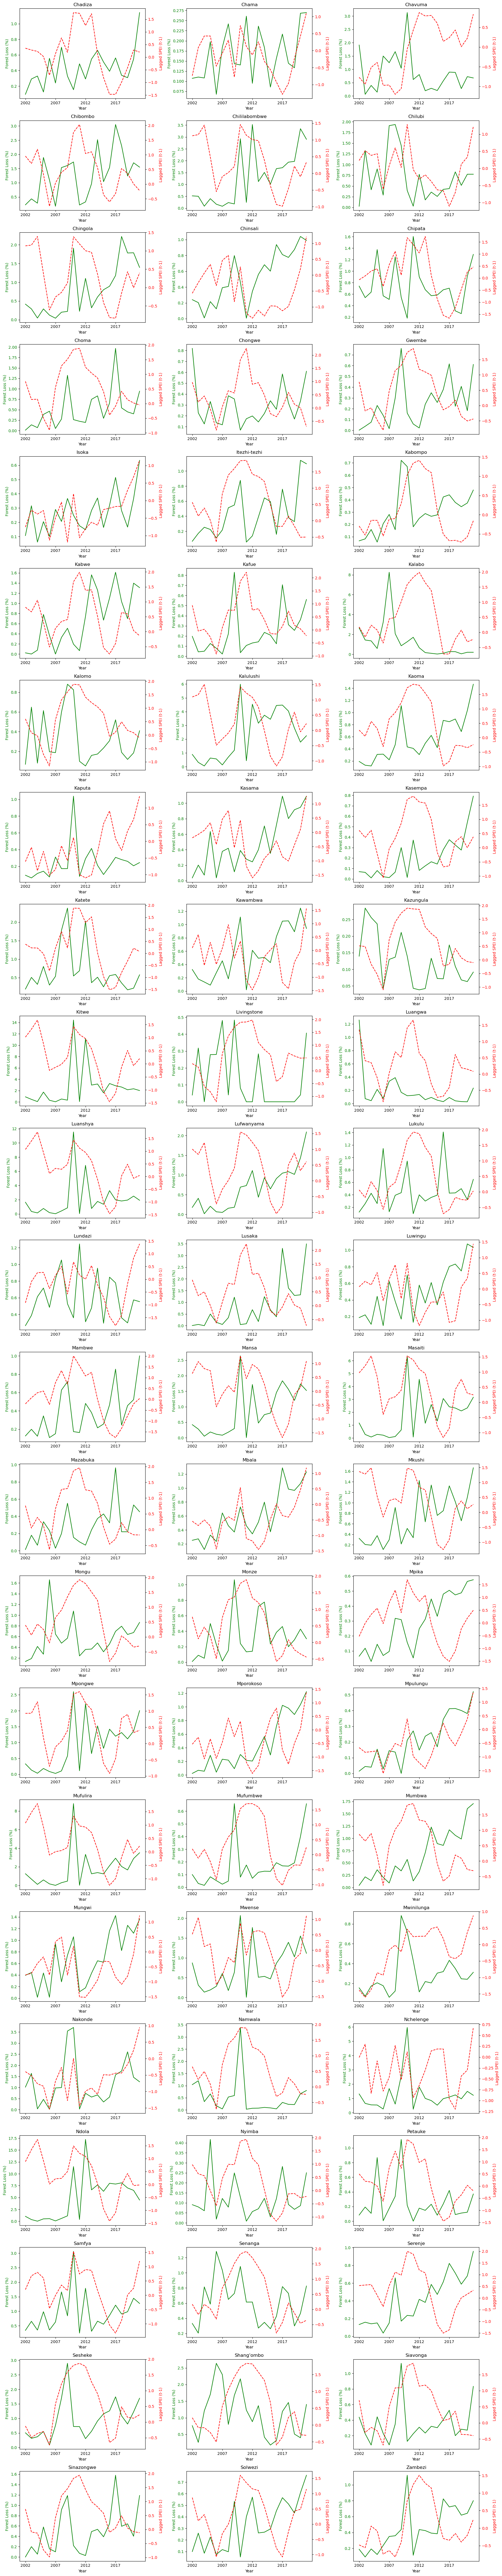

In [5]:
# drop missing values
plot_df = merged_df.dropna(subset=['district', 'year', 'mean_spei', 'percent_loss_annual'])
plot_df['year'] = plot_df['year'].astype(int)

# lag SPEI by 1 year within each district
plot_df['mean_spei_lag1'] = plot_df.groupby('district')['mean_spei'].shift(1)

# drop rows with NaNs after lagging
plot_df = plot_df.dropna(subset=['mean_spei_lag1'])

# get unique districts
districts = plot_df['district'].unique()

# set up plot grid
cols = 3
rows = (len(districts) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

# plot per district
for i, district in enumerate(districts):
    ax1 = axes[i]
    district_data = plot_df[plot_df['district'] == district].sort_values('year')
    
    # plot forest loss (left y-axis)
    ax1.plot(district_data['year'], district_data['percent_loss_annual'], label='Forest Loss (%)', color='green')
    ax1.set_ylabel('Forest Loss (%)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # plot lagged SPEI (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(district_data['year'], district_data['mean_spei_lag1'], label='Lagged SPEI (t-1)', color='red', linestyle='--')
    ax2.set_ylabel('Lagged SPEI (t-1)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(district)
    ax1.set_xlabel('Year')

    # label x-axis every 5 years
    min_year = district_data['year'].min()
    max_year = district_data['year'].max()
    ax1.set_xticks(range(min_year, max_year + 1, 5))

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [7]:
# compute correlation per district without the deprecated behavior
correlation_df = (
    plot_df.groupby('district')[['mean_spei_lag1', 'percent_loss_annual']]
    .apply(lambda g: g['mean_spei_lag1'].corr(g['percent_loss_annual']))
    .reset_index(name='spei_lag1_vs_forest_loss_corr')
)

# sort correlation in descending order
correlation_df = correlation_df.sort_values(by='spei_lag1_vs_forest_loss_corr', ascending=False)

# Display the first few rows
print(correlation_df.head(10))

     district  spei_lag1_vs_forest_loss_corr
47   Mpulungu                       0.623123
40      Mbala                       0.596150
12      Isoka                       0.504332
29    Luangwa                       0.408251
51     Mungwi                       0.405103
1       Chama                       0.399007
54    Nakonde                       0.329470
8     Chipata                       0.329066
46  Mporokoso                       0.326991
60     Samfya                       0.317748


In [10]:
# compute correlation and p-value per district
def compute_corr_pval(group):
    if len(group) < 3:  # not enough data
        return pd.Series({'correlation': None, 'p_value': None})
    r, p = pearsonr(group['mean_spei_lag1'], group['percent_loss_annual'])
    return pd.Series({'correlation': r, 'p_value': p})

# apply function to each district
correlation_df = (
    plot_df.groupby('district')[['mean_spei_lag1', 'percent_loss_annual']]
    .apply(compute_corr_pval)
    .reset_index()
)

# drop districts with NaNs 
correlation_df = correlation_df.dropna()

# sort by correlation in descending order
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

# show only significant results (p < 0.05)
significant_results = correlation_df[correlation_df['p_value'] < 0.05]

print(significant_results)

    district  correlation   p_value
47  Mpulungu     0.623123  0.003335
40     Mbala     0.596150  0.005535
12     Isoka     0.504332  0.023355
50    Mumbwa    -0.477880  0.033082


### Longer lags

In [19]:
def compute_lag_corrs(group):
    results = {}
    for lag in [1, 2, 3, 4, 5]:
        col = f'mean_spei_lag{lag}'
        if col in group:
            # drop NaNs
            valid = group[[col, 'percent_loss_annual']].dropna()
            if len(valid) >= 3:
                r, p = pearsonr(valid[col], valid['percent_loss_annual'])
                results[f'corr_lag{lag}'] = r
                results[f'pval_lag{lag}'] = p
            else:
                results[f'corr_lag{lag}'] = None
                results[f'pval_lag{lag}'] = None
    return pd.Series(results)

In [20]:
plot_df['mean_spei_lag2'] = plot_df.groupby('district')['mean_spei'].shift(2)
plot_df['mean_spei_lag3'] = plot_df.groupby('district')['mean_spei'].shift(3)
plot_df['mean_spei_lag4'] = plot_df.groupby('district')['mean_spei'].shift(4)
plot_df['mean_spei_lag5'] = plot_df.groupby('district')['mean_spei'].shift(5)

multi_lag_corrs = (
    plot_df.groupby('district')[['mean_spei_lag1', 'mean_spei_lag2', 'mean_spei_lag3', 'mean_spei_lag4', 'mean_spei_lag5', 'percent_loss_annual']]
    .apply(compute_lag_corrs)
    .reset_index()
)

# Filter and print significant correlations for each lag
for lag in [1, 2, 3, 4, 5]:
    corr_col = f'corr_lag{lag}'
    pval_col = f'pval_lag{lag}'
    
    significant = multi_lag_corrs[multi_lag_corrs[pval_col] < 0.05][['district', corr_col, pval_col]]
    
    print(f"\nSignificant correlations for Lag {lag} (p < 0.05):")
    print(significant.sort_values(by=corr_col, ascending=False).to_string(index=False))


Significant correlations for Lag 1 (p < 0.05):
district  corr_lag1  pval_lag1
Mpulungu   0.623123   0.003335
   Mbala   0.596150   0.005535
   Isoka   0.504332   0.023355
  Mumbwa  -0.477880   0.033082

Significant correlations for Lag 2 (p < 0.05):
district  corr_lag2  pval_lag2
Mpulungu   0.583815   0.010966
  Mwense  -0.484025   0.041815
   Mpika  -0.500763   0.034281
   Mansa  -0.522388   0.026147
 Chavuma  -0.606053   0.007676

Significant correlations for Lag 3 (p < 0.05):
district  corr_lag3  pval_lag3
Chingola  -0.489990   0.045865
 Serenje  -0.514450   0.034613
   Mpika  -0.565051   0.018102
 Chavuma  -0.576556   0.015405

Significant correlations for Lag 4 (p < 0.05):
district  corr_lag4  pval_lag4
  Mwense  -0.503563   0.046747
 Chavuma  -0.509872   0.043628
   Mpika  -0.516210   0.040654
 Luwingu  -0.539831   0.030897
  Kalomo  -0.540182   0.030766
Chingola  -0.632767   0.008521
Chinsali  -0.694464   0.002834

Significant correlations for Lag 5 (p < 0.05):
     district  c

## Growing Season SPEI vs. Total Forest Loss

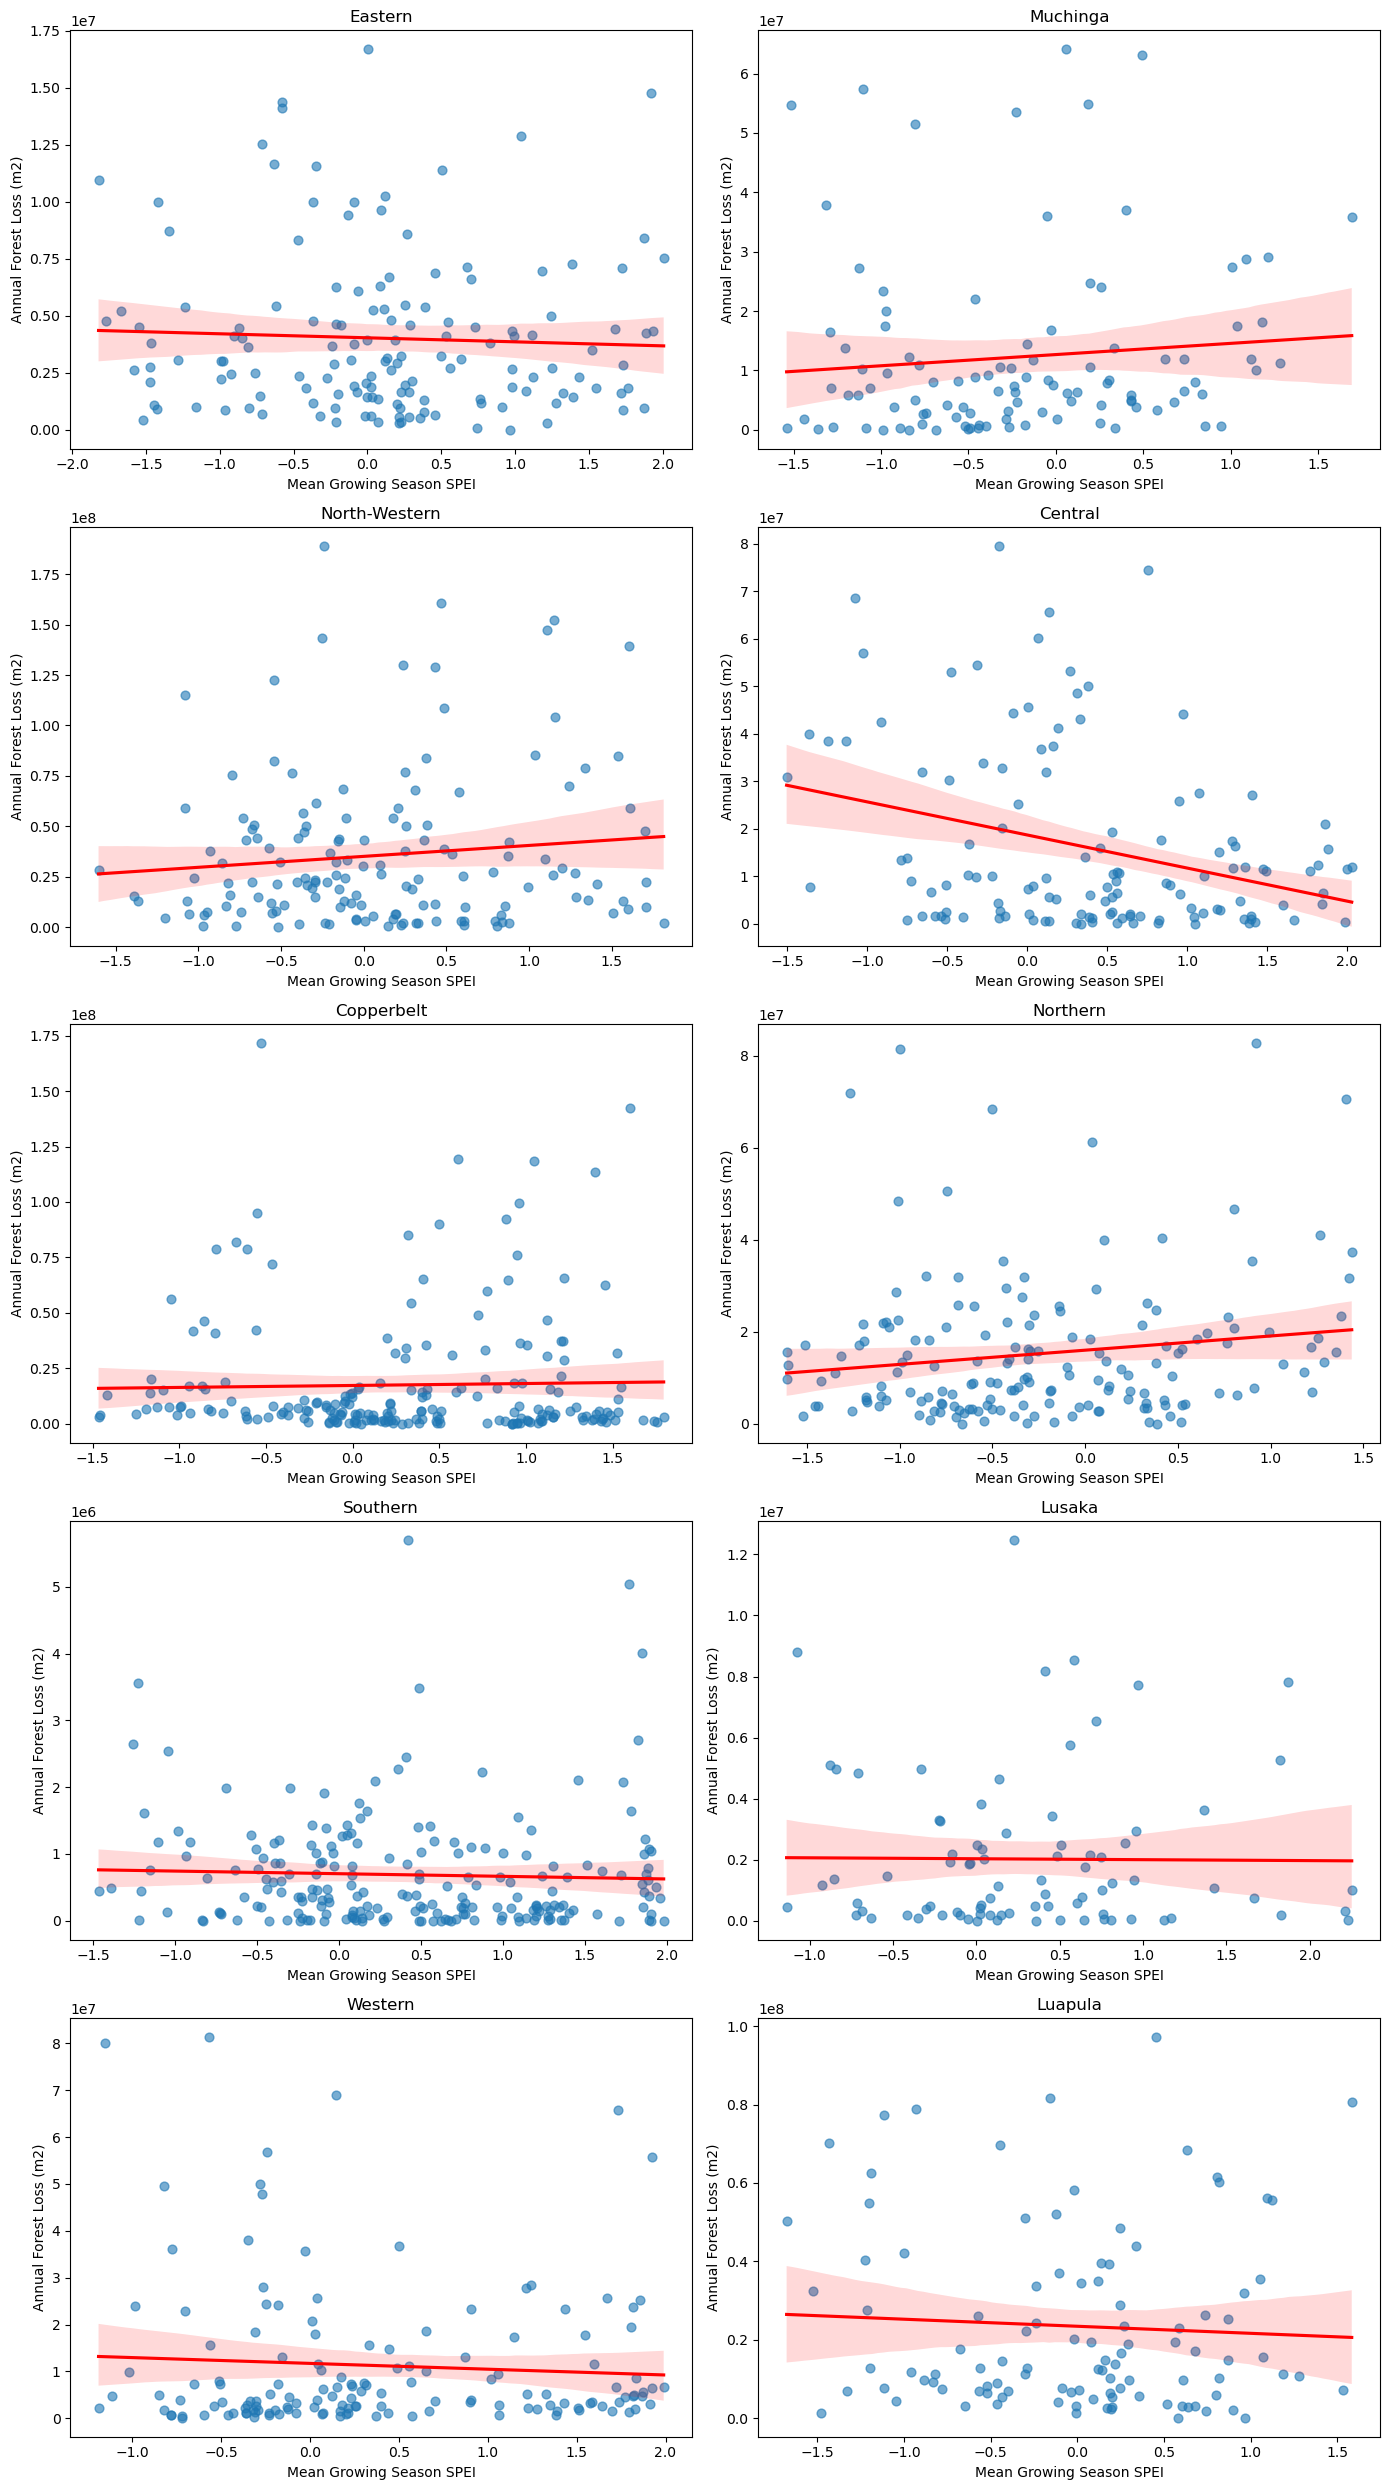

In [13]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'mean_spei', 'loss_m2', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='mean_spei',
        y='loss_m2',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Mean Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (m2)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

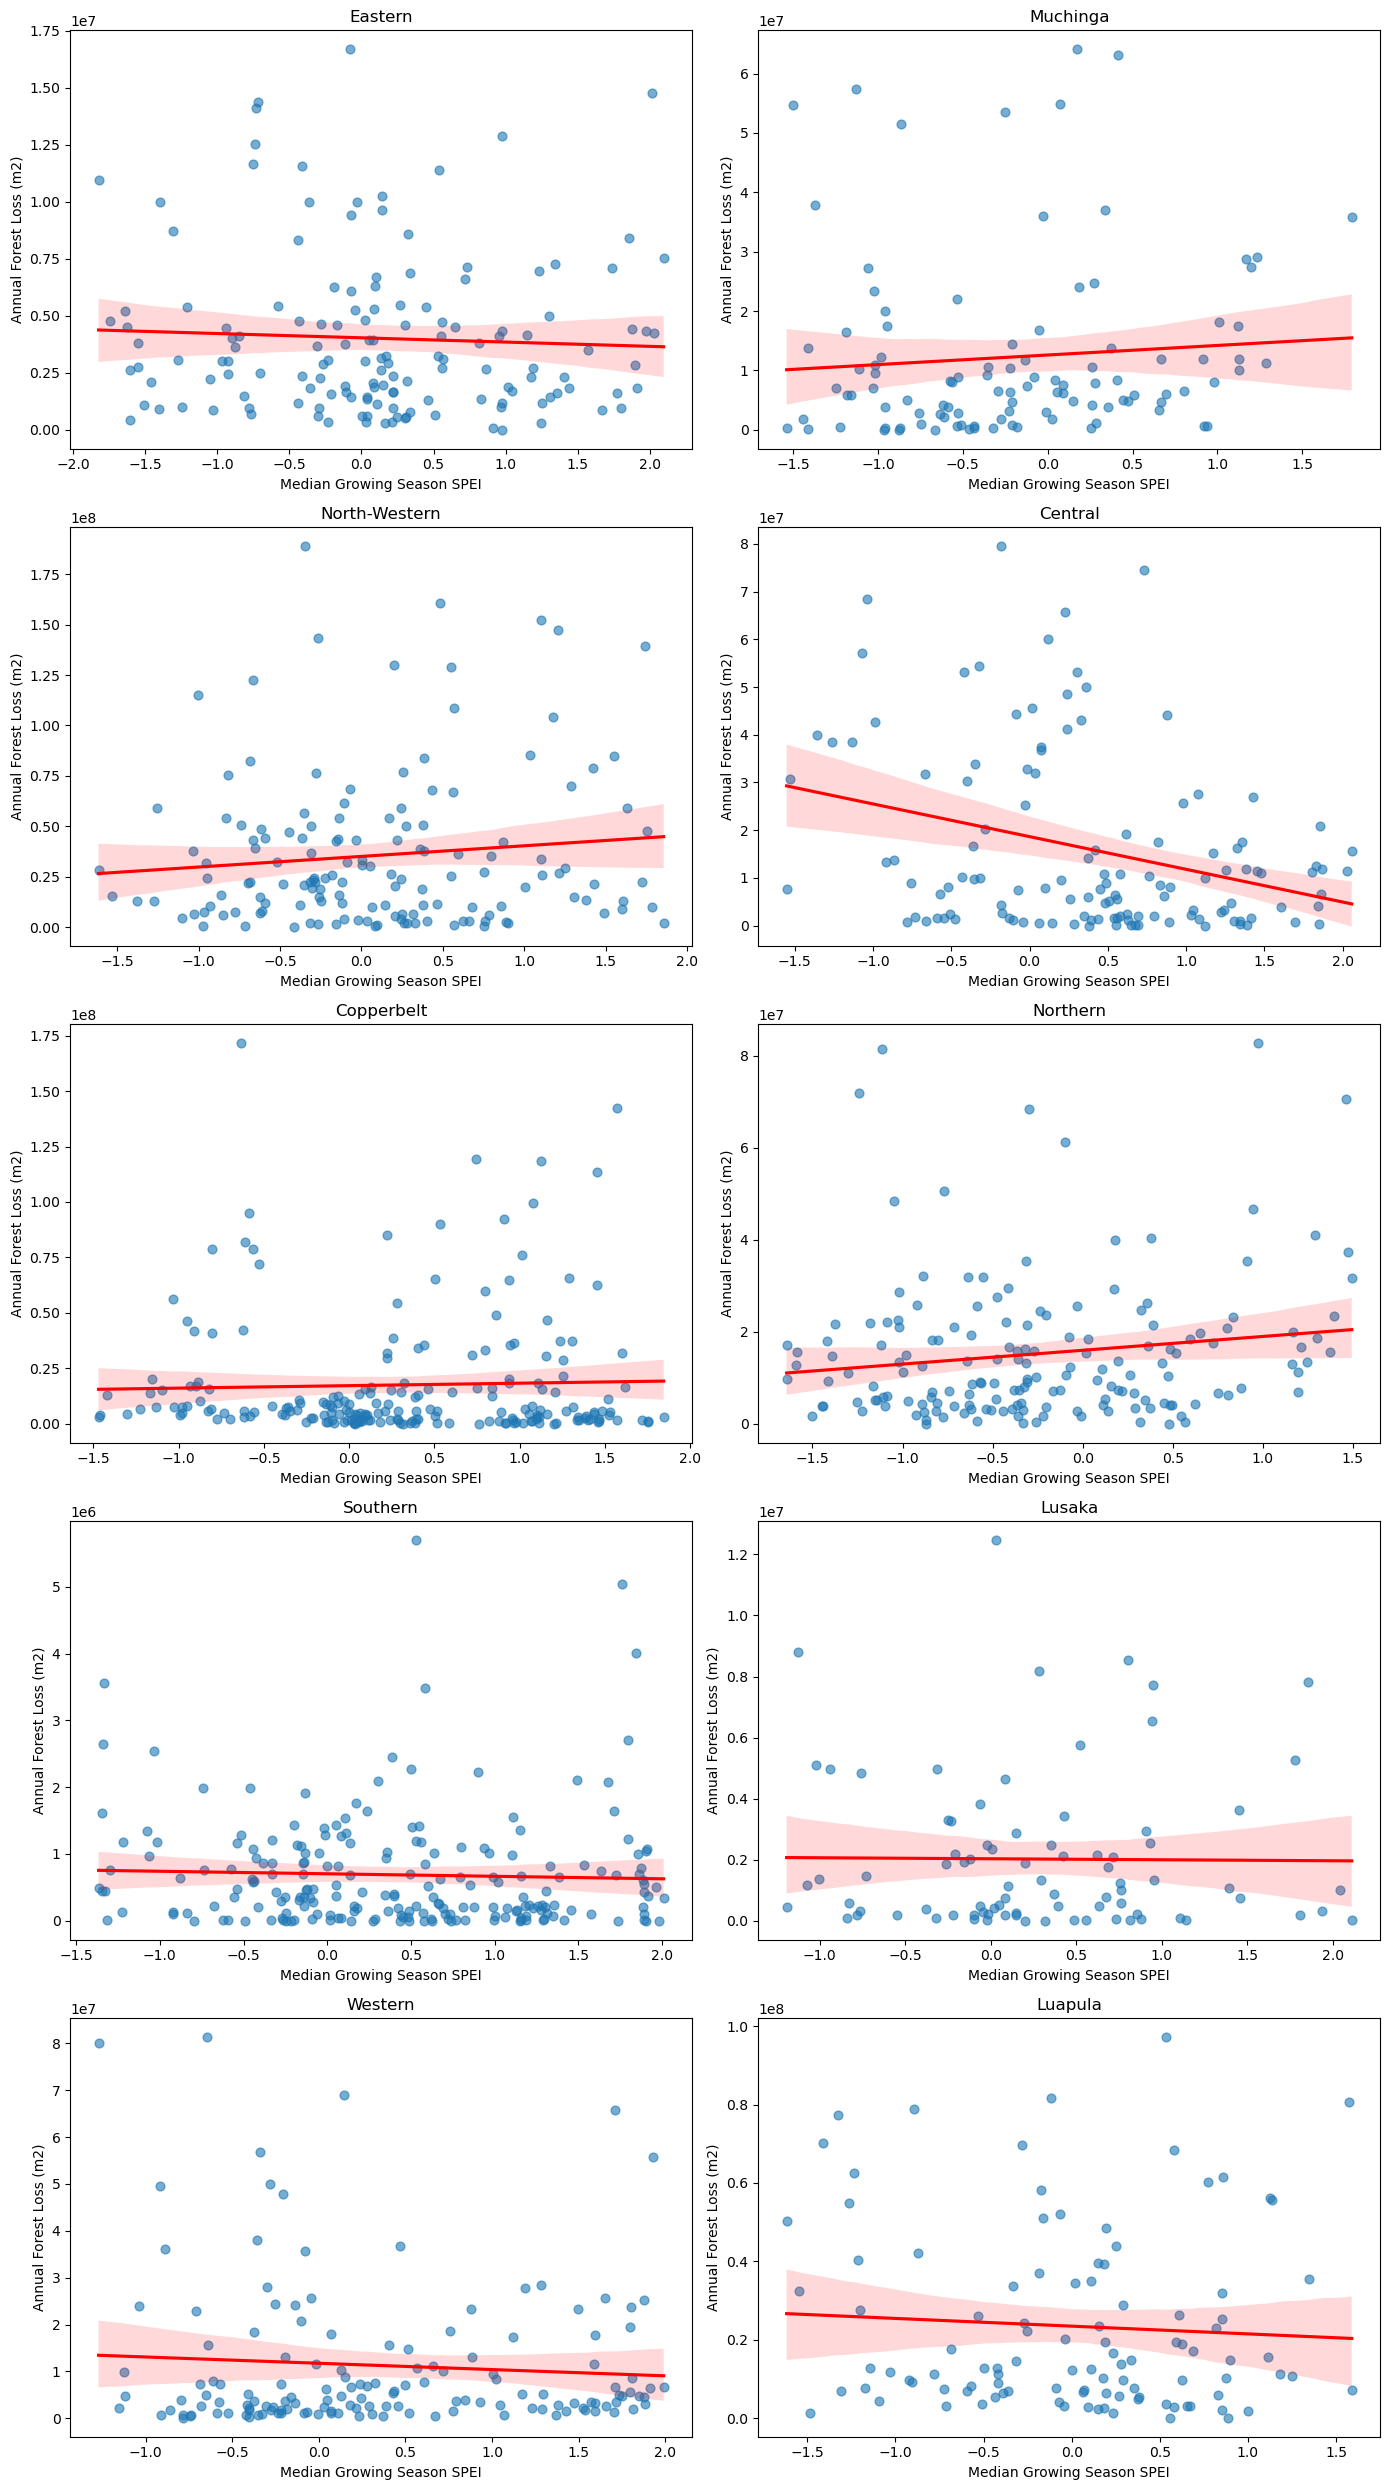

In [14]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'median_spei', 'loss_m2', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='median_spei',
        y='loss_m2',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Median Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (m2)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()